# Plot forces for flow past cylinder
## grid1 case, new code and new BC

In [1]:
%%capture
import sys
sys.path.insert(1, '../utilities')
import litCdData
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Basic problem parameters
D     = 6            # Cylinder diameter
U     = 20           # Freestream velocity
Lspan = 24           # Spanwise length
A     = D*Lspan      # frontal area
rho   = 1.225        # density
Q     = 0.5*rho*U*U  # Dynamic head
vis   = 1.8375e-5    # viscosity
ReNum = rho*U*D/vis  # Reynolds number

avgt = [230.0, 330.0] # Average times

In [3]:
# Load the force data
forcedat = np.loadtxt('forces01.dat', skiprows=1)
t        = forcedat[:,0]*U/D  # Non-dimensional time

In [4]:
# Calculate the Cl, Cd
Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)

In [5]:
# Calculate time average
def timeaverage(time, f, t1, t2):
    filt = ((time[:] >= t1) & (time[:] <= t2))
    # Filtered time
    t     = time[filt]
    # The total time
    dt = np.amax(t) - np.amin(t)
    #  Filtered field
    filtf = f[filt]
     # Compute the time average as an integral
    avg = np.trapz(filtf, x=t, axis=0) / dt
    return avg

# The Tukey window
# see https://en.wikipedia.org/wiki/Window_function#Tukey_window
def tukeyWindow(N, params={'alpha':0.1}):
    alpha = params['alpha']
    w = np.zeros(N)
    L = N+1
    for n in np.arange(0, int(N//2) + 1):
        if ((0 <= n) and (n < 0.5*alpha*L)):
            w[n] = 0.5*(1.0 - np.cos(2*np.pi*n/(alpha*L)))
        elif ((0.5*alpha*L <= n) and (n <= N/2)):
            w[n] = 1.0
        else:
            print("Something wrong happened at n = ",n)
        if (n != 0): w[N-n] = w[n]
    return w

# FFT's a signal, returns 1-sided frequency and spectra
def getFFT(t, y, normalize=False, window=True):
    n    = len(y)
    k    = np.arange(n)
    dt   = np.mean(np.diff(t))
    frq  = k/(n*dt)
    if window:    w = tukeyWindow(n)
    else:         w = 1.0
    if normalize: L = len(y)
    else:         L = 1.0
    FFTy = np.fft.fft(w*y)/L 
    
    # Take the one sided version of it
    freq = frq[range(int(n//2))]
    FFTy = FFTy[range(int(n//2))]
    return freq, FFTy

In [6]:
# Calculate averaged Cp, Cd
avgCd = timeaverage(t, Cd, avgt[0], avgt[1])
avgCl = timeaverage(t, Cl, avgt[0], avgt[1])
print("Avg Cd = %f"%avgCd)
print("Avg Cl = %f"%avgCl)

Avg Cd = 0.328288
Avg Cl = 0.021978


## Plot Lift and Drag coefficients

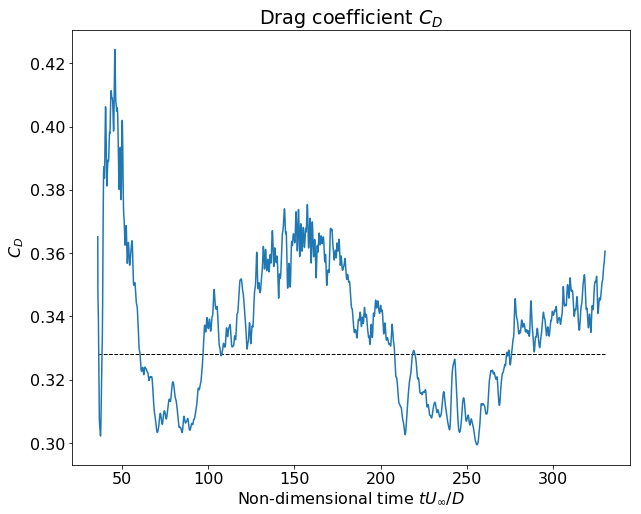

In [7]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.plot(t,Cd)
plt.hlines(avgCd, np.min(t), np.max(t), linestyles='dashed', linewidth=1)
plt.xlabel(r'Non-dimensional time $t U_{\infty}/D$');
plt.ylabel('$C_D$')
plt.title('Drag coefficient $C_D$');

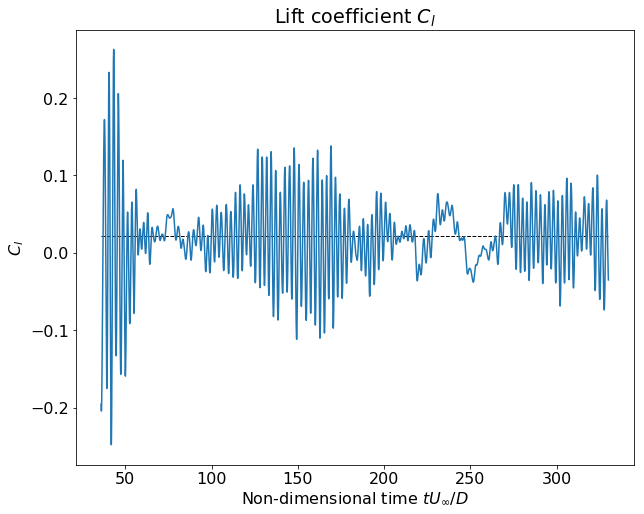

In [8]:
plt.figure(figsize=(10,8))
plt.plot(t,Cl)
plt.hlines(avgCl, np.min(t), np.max(t), linestyles='dashed', linewidth=1)
plt.xlabel(r'Non-dimensional time $t U_{\infty}/D$');
plt.ylabel('$C_l$')
plt.title('Lift coefficient $C_l$');

### Plot spectra

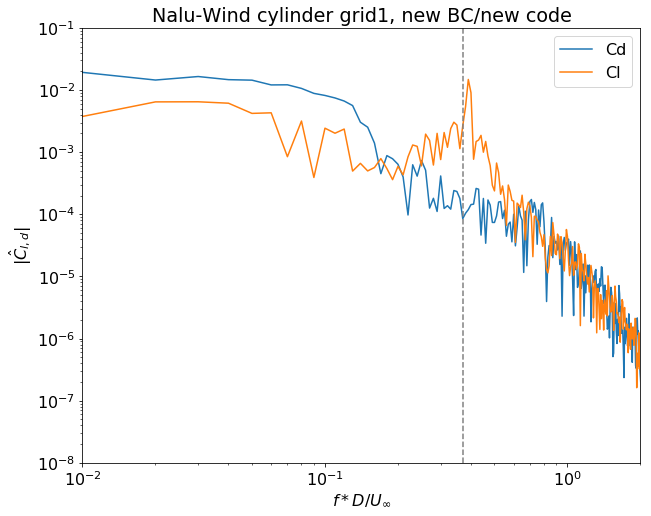

In [28]:
plt.figure(figsize=(10,8))
# Look at frequency content
avg  = [230.0, 330.0]
filt = ((t[:] >= avg[0]) & (t[:] <= avg[1]))
tfiltered = t[filt]*D/U
Cdfiltered = Cd[filt]
Clfiltered = Cl[filt]

f, Cdspectra = getFFT(tfiltered, Cdfiltered, normalize=True)
f, Clspectra = getFFT(tfiltered, Clfiltered, normalize=True)

plt.loglog(f*D/U, abs(Cdspectra), label='Cd')
plt.loglog(f*D/U, abs(Clspectra), label='Cl')
plt.axvline(0.37, linestyle='--', color='gray')
plt.xlim([1E-2,2]);
plt.ylim([1E-8, 1E-1]);
plt.xlabel(r'$f*D/U_\infty$');
plt.ylabel(r'$|\hat{C}_{l,d}|$')
plt.title('Nalu-Wind cylinder grid1, new BC/new code')
plt.legend()
#plt.ylim([0, 0.05])

## Plot Cd versus Reynolds number

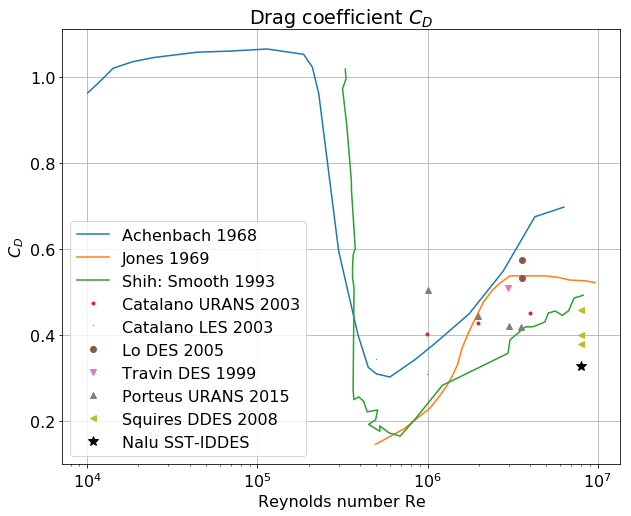

In [10]:
plt.figure(figsize=(10,8))
litCdData.plotEXP()
litCdData.plotCFD()
plt.semilogx(ReNum, avgCd, '*', color='k',  ms=10, label='Nalu SST-IDDES')
plt.grid()
plt.legend()

plt.xlabel(r'Reynolds number Re');
plt.ylabel('$C_D$')
plt.title('Drag coefficient $C_D$');

In [11]:
# Write the YAML file these averaged quantities
import yaml
savedict={'Re':float(ReNum), 'avgCd':float(avgCd), 'avgCl':float(avgCl)}
f=open('istats.yaml','w')
f.write('# Averaged quantities from %f to %f\n'%(avgt[0], avgt[1]))
f.write('# Grid: grid1\n')
f.write(yaml.dump(savedict, default_flow_style=False))
f.close()